# Required libraries

In [1]:
from PIL import Image
import os
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import cv2

# Function to read images from given path

In [2]:
def read_images(directory):
    image_data = []
    for file in os.listdir(directory):
        if file.endswith(".jpg"):
            image_path = os.path.join(directory, file)
            image = Image.open(image_path)
            pixel_data = np.array(image)
            image_data.append(pixel_data)
    return image_data

# 128 * 128 images
directory_path = "/kaggle/input/image-classification/images/images/architecure"
image_data_list = read_images(directory_path)
print(f'Number of images: {len(image_data_list)}')

Number of images: 8763


# Create gaussian noise and add it to picture

In [8]:
def gaussian_noise(shape, mean=10, std_dev=10):
    size = np.prod(shape)
    
    u1 = np.random.uniform(0, 1, size)
    u2 = np.random.uniform(0, 1, size)
    
    # Apply the Box-Muller transform to generate Gaussian noise
    z = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    
    # Reshape the noise array to the desired shape
    z = np.reshape(z, shape)
    
    # Use standard deviation and mean
    noise = std_dev * z + mean
    
    return noise


def add_gaussian_noise(image):
    mean = random.randint(25, 50)
    std_dev = random.randint(10, 50)
    noise = gaussian_noise(image.shape[:2], mean=mean, std_dev=std_dev)
    noisy_image = np.clip(image + noise[..., np.newaxis], 0, 255).astype(np.uint8)
    return noisy_image

# Check if Gaussian noise function works fine

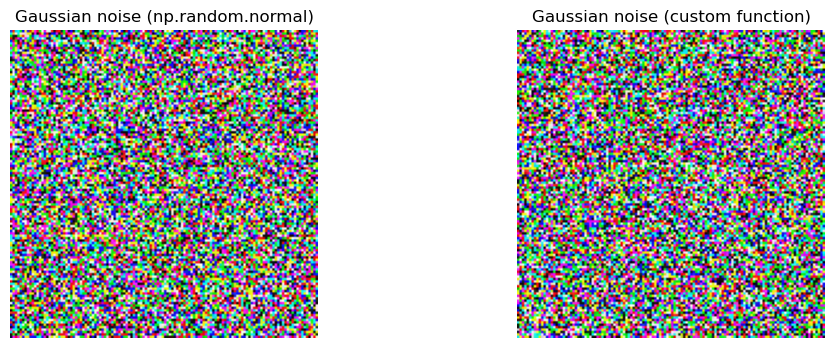

In [9]:
height = 128
width = 128
channels = 3

# Generate noise with both numpy and custom function
noise_np = np.random.normal(loc=0.0, scale=25.0, size=(height, width, channels))
noise_custom = gaussian_noise((height, width, channels), mean=0, std_dev=25)

# Display images of the two noises
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(noise_np.astype(np.uint8))
axs[0].axis('off')
axs[0].set_title('Gaussian noise (np.random.normal)')
axs[1].imshow(noise_custom.astype(np.uint8))
axs[1].axis('off')
axs[1].set_title('Gaussian noise (custom function)')
plt.show()

# Choose number of pictures to apply noise and denoise

In [5]:
# Choose first 10 images
first_10_images = image_data_list[:10]

Add gaussian noise to images and sotre in new list

In [10]:
# Add Gaussian noise to each image
noisy_images = [add_gaussian_noise(image) for image in first_10_images]

# Plot both original and noised pictures

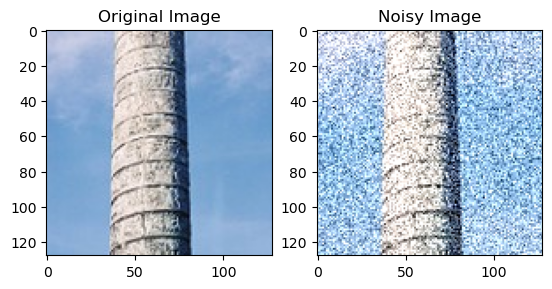

In [11]:
index = random.randint(0, 9)
# Display the first original image and its corresponding noisy image
original_image = Image.fromarray(image_data_list[index])
noisy_image = Image.fromarray(noisy_images[index])
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(noisy_image)
axes[1].set_title("Noisy Image")
plt.show()

# Gram schmidt algorithm

In [43]:
def gram_schmidt(A):
    Q = []
    for j in range(A.shape[1]):
        v = A[:,j]
        for i in range(len(Q)):
            q = Q[i]
            v = v - np.dot(v, q) * q
        if not np.allclose(v, 0):
            v = v / np.linalg.norm(v)
            Q.append(v)
    return np.column_stack(Q)

# Function for QR decomposition of a matrix

In [45]:
def QR(M):
    Q = gram_schmidt(M)
    R = np.dot(Q.T, M)
    return Q, R

# Calculate eigen values and eigen vectors

In [49]:
def eig(A, max_iterations=1000):
    dimension = A.shape[0]
    eigenvectors = np.identity(dimension)
    
    for i in range(max_iterations):
        # Calculate the QR decomposition of the matrix
        q, r = QR(A)

        # Multiply the matrix by Q and update the eigenvectors
        A = np.dot(r, q)
        eigenvectors = np.dot(eigenvectors, q)
        
        # Check if the off-diagonal elements are below a certain threshold
        off_diagonal = np.abs(A - np.diag(np.diag(A)))
        if np.max(off_diagonal) < 1e-8:
            break
            
    # Extract the eigenvalues from the diagonal of the matrix
    eigenvalues = np.diag(A)
    
    # Normalize the eigenvectors
    eigenvectors = eigenvectors / np.sqrt(np.sum(eigenvectors ** 2, axis=0))
    
    return eigenvalues, eigenvectors


# Implementation of SVD function

In [51]:
def svd(A):
    # Compute eigenvalues and eigenvectors of A^T.A
    ATA = np.dot(A.T, A)
    eigenvalues, V = eig(ATA)

    # Sort eigenvalues in descending order
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    V = V[:, sort_indices]

    # Compute singular values and U
    S = np.sqrt(np.abs(eigenvalues))
    U = np.dot(A, V) / S

    return U, S, V.T

# Test the SVD function

In [53]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Implemented SVD
U, SV, V = svd(A)
reconstructed_A = U @ np.diag(SV) @ V
# print(f'U:\n{U}\nSV:\n{SV}\nEigen:\n{Eigen}')

# SVD using np.linalg.svd
U, SV, V = np.linalg.svd(A)
reconstructed_A_with_np = U @ np.diag(SV) @ V

# Check if implemented SVD works fine
print(np.allclose(reconstructed_A, reconstructed_A_with_np))

True
